# Week 5
## Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Rock Musicians on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Rock Music Artists Network
* Properties of the network structure
* Finally some more visualizations

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into Section 9.4 in the exercises below. We will also talk a little bit about degree correlations - you can read about those in **Chapter 7**.

# Part A: Let's  visualise some more!

For the rest of the course, we will primarily use[`ForceAtlas2`](https://journals.plos.org/plosone/article%3Fid=10.1371/journal.pone.0098679), a layout algorithm which was developed by the creators of the [Gephy graph analysis software](https://gephi.org). IMHO it's the prettiest network layout algorithm & since last year it's been implemented in NetworkX, so it should be easy to use.

*Exercise 1:* Plot the Network using ForceAtlas2. For visualization, you should work with the network from last time, the Giant Connected Component ... and the undirected version.

> * Visualize the network using NetworkX
>   * Node color should depend on the `length_of_content` attribute (see notes from last week).
>   * Node size should depend on the node *degree*
> * Play with the force atlas algorithm parameters to obtain a visualization you like. 

<div class="alert alert-block alert-info">
It's OK to use your LLM as much as needed for this exercise. The only goal is to create a nice visualization.
</div>

In [1]:
import requests
import os
from urllib.parse import quote
import time
import json
from pathlib import Path
import numpy as np
import re
#We made a wikipediadownloader class that downloads and saves the json version of a wikipedia page

class WikipediaDownloader:
    def __init__(self):
        self.base_url = "https://en.wikipedia.org/w/api.php"

        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })

    def download_page_html(self, title):
        try:
            params = {
                "action": "query",
                "prop": "revisions",
                "rvprop": "content",
                "format": "json",
                "titles": title.replace(' ', '_'),  # Use the actual title parameter
                "rvslots": "main"
            }
            print(f"Downloading: {title}")
            response = self.session.get(self.base_url, params=params)

            response.raise_for_status()
            return response.text
        except requests.RequestException as e:
            print(f"Error downloading {title}: {e}")
            return None

    def save_page(self, title, content):
        if content is None:
            return False

        # Create directory if it doesn't exist
        os.makedirs("wikipedia_pages", exist_ok=True)

        # Clean filename
        safe_filename = "".join(c for c in title if c.isalnum() or c in (' ', '-', '_')).rstrip()
        filename = f"wikipedia_pages/{safe_filename}.json"

        try:
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(content)
            print(f"Saved: {filename}")
            return filename
        except IOError as e:
            print(f"Error saving {title}: {e}")
            return False

    def download_and_save(self, title):
        content = self.download_page_html(title)

        if content:
            return self.save_page(title, content)
        return False

downloader = WikipediaDownloader()

favorite_pages = [
    "List of mainstream rock performers"
]
for page_title in favorite_pages:
    print(f"\n--- Processing: {page_title} ---")

    # Download HTML version
    file_name = downloader.download_and_save(page_title)
    if(file_name):
        print(f"Successfully downloaded and saved: {file_name}")
    else:
        print(f"Failed to download or save: {page_title}")


--- Processing: List of mainstream rock performers ---
Downloading: List of mainstream rock performers
Saved: wikipedia_pages/List of mainstream rock performers.json
Successfully downloaded and saved: wikipedia_pages/List of mainstream rock performers.json


In [2]:
#We extracted the artists from the mainstreem rock performers wiki
import json
with open("wikipedia_pages/List of mainstream rock performers.json", "r") as f:
    html_content = f.read()

#we had to decode the json because of the special characters
parsed_json = json.loads(html_content)
page_id = list(parsed_json['query']['pages'].keys())[0]
wiki_text = parsed_json['query']['pages'][page_id]['revisions'][0]['slots']['main']['*']

# Now extract from the properly decoded text
pattern = r'\[\[([^\]|]+)'

In [3]:

import re
# Find the artists and saved them to the artists.txt
matches = re.findall(pattern, wiki_text)

# Optional: remove duplicates and sort
artists = sorted(set(matches))

# Save to a text file
with open("artists.txt", "w", encoding="utf-8") as f:
    for artist in artists:
        f.write(artist + "\n")

print(f"Extracted {len(artists)} artists and saved to artists.txt")

Extracted 492 artists and saved to artists.txt


In [4]:
# Open the file in read mode
artists_file_names = []
with open("artists.txt", "r", encoding="utf-8") as file:
    for line in file:
        artist = line.strip()  # remove leading/trailing spaces and newline
        file_name = downloader.download_and_save(artist)
        if(file_name):
            artists_file_names.append(file_name)
        else:
            print(f"Failed to download or save: {page_title}")

Downloading: 10 Years (band)
Saved: wikipedia_pages/10 Years band.json
Downloading: 10cc
Saved: wikipedia_pages/10cc.json
Downloading: 3 Doors Down
Saved: wikipedia_pages/3 Doors Down.json
Downloading: 311 (band)
Saved: wikipedia_pages/311 band.json
Downloading: 38 Special (band)
Saved: wikipedia_pages/38 Special band.json
Downloading: A Perfect Circle
Saved: wikipedia_pages/A Perfect Circle.json
Downloading: ABBA
Saved: wikipedia_pages/ABBA.json
Downloading: AC/DC
Saved: wikipedia_pages/ACDC.json
Downloading: AFI (band)
Saved: wikipedia_pages/AFI band.json
Downloading: Accept (band)
Saved: wikipedia_pages/Accept band.json
Downloading: Adam Ant
Saved: wikipedia_pages/Adam Ant.json
Downloading: Aerosmith
Saved: wikipedia_pages/Aerosmith.json
Downloading: Air Supply
Saved: wikipedia_pages/Air Supply.json
Downloading: Alanis Morissette
Saved: wikipedia_pages/Alanis Morissette.json
Downloading: Alice Cooper
Saved: wikipedia_pages/Alice Cooper.json
Downloading: Alice Cooper (band)
Saved: wi

In [5]:
#we saved the artists to an artist_array so that it will be easier to iterate through them later
artist_array = []
with open("artists.txt", "r", encoding="utf-8") as file:
    for line in file:
        artist_array.append(line.strip())  # remove leading/trailing spaces and newline

In [6]:
# We made a function that checks if an artist is referenced in another artist's wikipedia page
def find_referenced_artists(artist_to_find, current_artist, current_artist_file_name):
    file_path = current_artist_file_name
    with open(file_path, "r", encoding="utf-8") as f:
        wiki_html = f.read()

    # Find all wiki links with regex
    pattern = r"\[\[" + re.escape(artist_to_find) + r"(?:\|[^\]]+)?\]\]"

    if re.search(pattern, wiki_html):
        return True
    else:
        return False

In [8]:
#We made a directed graph and added the artists as nodes and if an artist referenced another artist in his wikipedia page we added a directed edge from the first artist to the second artist.
import networkx as nx
rock_artists_graph = nx.DiGraph()

for artist in artist_array:
    rock_artists_graph.add_node(artist)

for index in range (len(artist_array)):
    artist = artist_array[index]
    artist_file_name = artists_file_names[index]
    for artist_to_find in artist_array:
        if artist != artist_to_find:
            if find_referenced_artists(artist_to_find, artist, artist_file_name):
                rock_artists_graph.add_edge(artist, artist_to_find)

In [9]:
#after analysing the data, we found a couple of strings that needed to be removed
rock_artists_graph.remove_node('Category:Lists of rock musicians')
rock_artists_graph.remove_node('Category:Lists of rock musicians by subgenre')
rock_artists_graph.remove_node('AllMusic')

In [17]:
#We made a helper function that extracts the text from the Wikipedia json structure
#We used llm to help us with this 2 functions
def extract_wiki_text(data):
    pages = data["query"]["pages"]
    first_page = next(iter(pages.values()))
    return first_page["revisions"][0]["slots"]["main"]["*"]

#We made a function that returns the number of words in a json file based on the regex as below
def word_count(current_artist_file_name):
    file_path = Path(current_artist_file_name)
    with file_path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    text = extract_wiki_text(data)

    text = re.sub(r"\s+", " ", text).strip()

    words = re.findall(r"\b[\w’-]+\b", text, flags=re.UNICODE)

    return len(words)

In [18]:
#We connect the artists_file_names with the artist_arrays to create a dictionary
artists_to_path = dict(zip((artist_array), (artists_file_names)))

word_count_array = []
for artist in rock_artists_graph.nodes():
    file_path = artists_to_path[artist]
    word_num = word_count(file_path)
    word_count_array.append(word_num)

In [19]:
artists_to_dict = {}
for index, item in enumerate(list(rock_artists_graph.nodes.items())):
    artists_to_dict[item[0]] = word_count_array[index]

nx.set_node_attributes(rock_artists_graph, values = artists_to_dict, name = "word_count")

In [22]:
#We made a function that disconnect nodes that don't have any edges
def disconnect_node(graph_name):
    nodes_with_no_out_degree = []
    for node in graph_name:
        if graph_name.out_degree(node) == 0 and graph_name.in_degree(node) == 0:
            nodes_with_no_out_degree.append(node)

    graph_name.remove_nodes_from(nodes_with_no_out_degree)
    disconnected = nodes_with_no_out_degree
    return disconnected

disconnect = disconnect_node(rock_artists_graph)
print(f"Disconnected nodes: ", disconnect)

Disconnected nodes:  []


In [23]:
#We search for the largest component
largest_component_sort = sorted(nx.weakly_connected_components(rock_artists_graph), key=len, reverse=True)
largest_component = rock_artists_graph.subgraph(largest_component_sort[0])

# add who is the largest component with number of edges and nodes

largest_component_nodes = largest_component.number_of_nodes()
print(f"The number of nodes of the largest component is: ", largest_component_nodes)

#number of links
largest_component_edges = largest_component.number_of_edges()

print("The number of links in the largest component is:", largest_component_edges)

The number of nodes of the largest component is:  485
The number of links in the largest component is: 7502


In [24]:
import pickle
with open("../files/rock_artists.p", 'wb') as f:
    pickle.dump(rock_artists_graph, f)

In [25]:
#load the rock artists graph
with open("../files/rock_artists.p", 'rb') as f:  # notice the r instead of w
    rock_artists_graph_loaded = pickle.load(f)

In [26]:
nx.forceatlas2_layout(rock_artists_graph_loaded)

{'10 Years (band)': array([1234.4735 ,  147.43175], dtype=float32),
 '10cc': array([1514.822   , -106.423454], dtype=float32),
 '3 Doors Down': array([1126.5396 , -191.82565], dtype=float32),
 '311 (band)': array([1675.1946 ,   58.86912], dtype=float32),
 '38 Special (band)': array([1512.9174 , -107.49968], dtype=float32),
 'A Perfect Circle': array([1563.7833 ,  112.10489], dtype=float32),
 'ABBA': array([1772.1538, -386.0947], dtype=float32),
 'AC/DC': array([1476.1925, -182.3968], dtype=float32),
 'AFI (band)': array([1513.0919 ,  399.23483], dtype=float32),
 'Accept (band)': array([1241.1877 , -225.03848], dtype=float32),
 'Adam Ant': array([1952.9856 ,  114.12671], dtype=float32),
 'Aerosmith': array([1440.6322 ,  -72.65314], dtype=float32),
 'Air Supply': array([1570.9641 , -193.07512], dtype=float32),
 'Alanis Morissette': array([1609.5209  ,   25.137192], dtype=float32),
 'Alice Cooper': array([1709.7902  ,  -49.720993], dtype=float32),
 'Alice Cooper (band)': array([1367.143  

*Exercise 2*: We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data manually will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

> 1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>    * Consider the set of neighbours pointing towards the node found above. 
>    * What is the relation between the band/mucisians you identified and their network neighbours? (e.g. did they sing a song together, did one write a song for the other?, etc ...). You don't need to come up with a grand theory of Rock Music here, I just want you to think about how links arise, why the links are there.
>    * Repeat the exercise for the highest out-degree node. 
>    * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia. Answer in your own words.
> 4. Create a scatter plot, where each node is a point, and the axes show in- versus out-degree. That way you can visually inspect the patterns of how in- and out-degree are connected across all the nodes in the network. Comment on what you see.
> 5. Are there any nodes with high(ish) out-degree and with few incoming connections? If yes, open WikiPages of those bands/mucisians and explain what happens?
> 6. Are there any nodes with high in-degree and few going connections? Again, open the WikiPages corresponding to those nodes and explain what happens?

<div class="alert alert-block alert-info">
For this one, I hope you'll limit your LLM use. It's OK to get help in creating the scatter plot, but use NetworkX on your own to identify nodes, and do your own reading and interpreting of Wiki pages.
</div>

# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

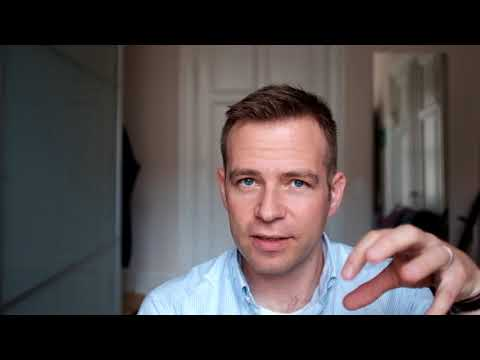

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 3:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

> 1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
> 2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. Think about what you learned in the book - what does each exponent say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * Reflect on the whole power-law thing. Are the degree distributions even power laws? Could a log-normal or exponential distribution be better? How would you find out what the right function to describe the various degree distributions are? 
>    * A long time ago, a group of scientists analyzed the network spanned by **all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 
> 3. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. Zoom in on just the in-degree $[0,20]$ and out-degree $[0,20]$ area of the plot. What is the advantage of using a heatmap over the scatter plot from the previous Exercise (especially for understanding what's going on in this area)?
> 4. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version? Which questions? Can you think of examples when the in/out distinction doesn't matter.
> 5. We have one more metric that we have used, but not investigated so far. The node-attribute `length_of_content`. There are two things to look at.
>    * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it? 
>    * Secondly, and more interestingly, it could be that longer texts means *more famous* characters. And that means more in-links. 
>    * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using [spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) or [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlations, fit a curve to the data, you decide). Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words.

<div class="alert alert-block alert-info">
For this exercise, I also hope you'll limit your LLM use. Especially for the intrepretation parts. It's OK to get help for the heatmap in sub-part 3, maybe also for ideas of how to do the testing in part 5. But do your own interpretation :)
</div>

*Exercise 4:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. 
> 1. Find the 5 most central characters according to degree centrality. 
> 1. Find the 5 most central characters according to betweenness centrality. 
>    * Repeat Exercise 1 (plotting the network). However, this time use *betweenness centrality* to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network? 
> 2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>    * Repeat Exercise 1 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
> 3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>     * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
> 4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
> 5. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect do the `length_of_content` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?.
>      * Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
> 6. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>    * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

<div class="alert alert-block alert-info">
As in the two previous exercises, I hope you'll limit your LLM use. Try to get a sense of working with NetworkX. And to grow your brain, do your own intrepretation parts ... it's difficult, but that's how you grow.</div>

# Part C: Backbones and Network Visualization 

One method to clean up the "hairball"-looking networks, is known as the [backbone method](https://www.pnas.org/doi/10.1073/pnas.0808904106). Sometimes this method is also called the "disparity filter". I explain what it's all about in the video below.

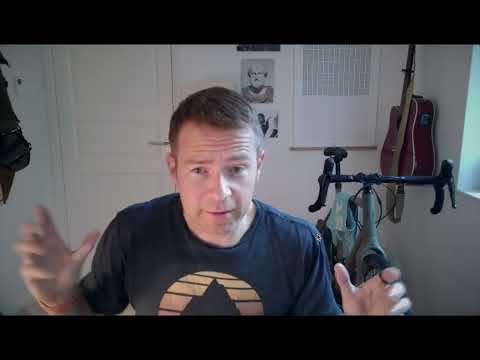

In [2]:
YouTubeVideo("GOvsrVulbsg", width=800, height=450)

There are [many backbone extraction algorithms](https://www.michelecoscia.com/?page_id=287), and I've chosen to talk about the *Disparity Filter* here, because it's the oldest and most commonly used method (so I though you should know about it). Plus, it'll probably be the relevant method for your project.

This choice, however, presents us with a problem: As I explain in the video, the Disparity Filter method *only works on weighted networks*. But our network does not have edge weights in any kind of natural way (since there's usually just a single link between two wiki pages). 


So to get rid of unimportant edges, we'll have to try something different. I present you with three possible methods below. For the first two ones, we'll add weights proportional to the [edge betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html). The edge betweenness centrality is just like the node betweenness centrality that you know and love ... only that it's defined for *edges* instead of nodes.

We can create two new weighted networks based on the edge betweenness
 * **Weighted Network 1**: The ***undirected*** Rock Music Network (Giant Connected Component) but with edge weights proportional to the edge betweenness centrality (let's renormalize so that the lowest weight is equal to 1 and the highest weight is equal to 100).
 * **Weighted Network 2**: The ***undirected*** Rock Music Network  (Giant Connected Component) but with edge weights proportional to 1/(edge weight in Weighted Network 1).

The third strategy (resulting in **Weighted network 3**) is to use a method designed for extracting structure from undirected networks: The [**High-Salience Skeleton**](https://www.nature.com/articles/ncomms1847). It's implemented as part of [this backbone extraction package](https://www.michelecoscia.com/?page_id=287)


Now we're ready for the exercise.


*Exercise 5*: Visualizing the Network Backbone

> 1. Extract the network backbone for both Weighted Network 1, 2, and 3. You can implement the disparity filter yourself based on the [scientific paper](https://www.pnas.org/doi/10.1073/pnas.0808904106) or find an implentation on GitHub (there are several ones to choose from ... I like [this implementation](https://www.michelecoscia.com/?page_id=287), which also includes other interesting edge filters). Figure out how your particular backbone extractor works (you may have to inspect the code itself, these packages are not always well documented). Play around with values of $\alpha$ to get an aestetically pleasing visualization (but don't make the resulting network too sparse).
> 2. Plot the resulting three networks using ForceAtlas2, still sizing nodes according to total degree. No need to color them. If your backbone has some disconnected nodes, feel free to not plot them. And remember to calculate a new layout to see how the structure has changed.
> 3. Comment on your results
>    * Do you see any structures in the networks now? Inspect some nodes to get a sense of what the structures captures in the three networks. Describe your findings in your own words.
>    * Weighted network 1, 2, and 3 are very different. In 1 and 2, we have removed edges with low/high edge betweenness centrality respectively and HSH is based on shortest paths. What have the various filters done to the networks? Describe what you see visually, and your explain your thoughts on what we've done to the network structures.

<div class="alert alert-block alert-info">
There's a lot to do today, so knock youself out with your LLM for this exercise, hopefully it can make your life easier (although I hope you'll do a bit of your own thinking, since a lot of complicated conceptual things are going on with the interplay between the backboning and edge betweenness and inverse edge betweenness!)</div>

One final thing. For now, the backbones are mostly for visualization. Especially because the edge weights are a bit artificial. Generally, it's not exactly clear what kind of information we get rid off when removing the non-backbone edges -- and in our case it's even less clear because I've made up two of the methods. Thus, we'll still do the exercises during the following weeks using the full network that preserves all of the connection information.
